In [1]:
# Activations & Gradients, BatchNorm

# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb
# https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#### Set Up
##### as before

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) # * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) #* 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) #* 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


In [ ]:
#plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item()

split_loss('train')
split_loss('val')
tracking_stats = ['Model 1',split_loss('train'),split_loss('val')]

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

### Multiple things are wrong with the modeL:
##### a. First loglikelihood is very high: what initial loss would you expect? given a uniform distribution
##### So at initialization we should plug in a uniform distribution, so every character is equally likely
##### -> this means setting b2 to zero
##### -> setting W2 close to zero: multiply by 0.01 or so: why not set it to zero?

In [ ]:
# expected probability is 1/27
-torch.tensor(1.0/27.0).log()

In [ ]:
logits = torch.tensor([7.0,-4.0,1.0,0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print("Very high loss:", loss.item(), " given the probabilities:", probs)

In [ ]:
logits = torch.tensor([0.0,0.0,0.0,0.0]) # should be set to equal in the initialization
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print("First guess of the loss would be:", loss.item(), "given probs:", probs)

#### so here is the reviseted code: b2 = b2 * 0; W2 = W2 * 0.01

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) # * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item()

split_loss('train')
split_loss('val')
tracking_stats = tracking_stats , ['Model 2:  b2*0; W2=W2*0.01',split_loss('train'),split_loss('val')]
tracking_stats

In [ ]:
#plt.plot(lossi)

### b. Solved loss with respect to logits, BUT Still a problem with initialization 
#### look at values of h (activations of hidden states) -> many values are 1 or -1

In [ ]:
# Preactivation
#plt.hist(hpreact.view(-1).tolist(), bins=50)

In [ ]:
# Activation
#plt.hist(h.view(-1).tolist(), bins=50)

### This is problematic!

#### depending on the function where you have flat areas (as in tanh), the neurons could by chance end up to be 1 and -1 (or 1 and 0). So these neurons never learn: permanent brain damage in the neural net

In [ ]:
# Create a distirbution with a larger variance (mean = zero)
a = torch.empty(10000).normal_(mean=0,std=1.5)
#plt.hist(a.view(-1).tolist(), bins=50)

In [ ]:
a2 = torch.tanh(a)
#plt.hist(a2.view(-1).tolist(), bins=50)

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

# Activation
plt.hist(h.view(-1).tolist(), bins=50)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

tracking_stats = tracking_stats , ['Model 3:  W1=0.01; b2=0; W2=W2*0.01',split_loss('train'),split_loss('val')]
tracking_stats

### This Problem gets worse, when you have more layers
#### What is the value you should multiply W with to preserve a standard deviation of 1 for hpreact = embcat @ W1 + b1

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(f'Mean x: {x.mean():.6f}, Std x: {x.std():.6f}')
print(f'Mean w: {w.mean():.6f}, Std w: {w.std():.6f}')
print(f'Mean y: {y.mean():.6f}, Std y: {y.std():.6f}')

#### Answer: * 1 / (10**0.5)
#### We should also add a gain: multiply by (5/3) divide by fan_mode. no clue why
#### So: * (5/3)/((n_embd * block_size)**0.5) #* 0.2

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(f'Mean x: {x.mean():.6f}, Std x: {x.std():.6f}')
print(f'Mean w: {w.mean():.6f}, Std w: {w.std():.6f}')
print(f'Mean y: {y.mean():.6f}, Std y: {y.std():.6f}')

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * (5/3) / 30**0.5
y = x @ w
print(f'Mean x: {x.mean():.6f}, Std x: {x.std():.6f}')
print(f'Mean w: {w.mean():.6f}, Std w: {w.std():.6f}')
print(f'Mean y: {y.mean():.6f}, Std y: {y.std():.6f}')

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

# Activation: still looks bad though....
plt.hist(h.view(-1).tolist(), bins=50)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


tracking_stats = tracking_stats , ['Model 4:  W1=(5/3)/((n_embd * block_size)**0.5); b2=0; W2=W2*0.01',split_loss('train'),split_loss('val')]
tracking_stats

### Batch Normalization
#### We want the preactivation function not procuding values that are very small (tanh produces -1) neither way too large (tanh produces ones)
#### We want them to be roughly Gaussian: subtract mean divide by standard deviation
#### Addtionally to batch normalization: we want the network not to be forced to be Gaussian. So we want it to be able to shift and deviate from that distribution

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters

# Addtionally to batch normalization: we want the network not to be forced to be Gaussian
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bngain]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
 
 
  # Batch Normalization NEW
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
 
 
 
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


In [ ]:
for i in range(10):
    print(i)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

tracking_stats = tracking_stats , ['Model 5:  Batch Normalization',split_loss('train'),split_loss('val')]
tracking_stats

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

### what we have achieved so far:

Negative Loglikelihood
| Step | Train | Test |
| :- | -: | :-: |
| Standard | 2.1276 | 2.1701 |
| W2 * 0.01 and b2 * 0 | 2.2556 | 2.3397 |
| + W1 * 0.01 and b1 * 0.01 | 2.1016 | 2.1513 |
| equally distributed values and b1 * 0.01 | 2.1051 | 2.1384 |
| Improving Gradient | 2.0377 | 2.1032 |
| Batch Normalization | 2.0411 | 2.1137 |

### Batch normalization has a regulaizing effect

#### achieving gaussian distribution is easy in a neural network with just one layer, but gets more complicated the more layers there are involved

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters

# Addtionally to batch normalization: we want the network not to be forced to be Gaussian
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running =  torch.ones((1, n_hidden))

bnmean_running2 = torch.zeros((1, n_hidden))
bnstd_running2 =  torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 # + b1 # because b1 gets canceled out during batch normalization!
 
 
  # Batch Normalization NEW
  bnmeani = hpreact.mean(0, keepdim= True)
  bnstdi = hpreact.std(0, keepdim= True) + 0.001  # add a small error so if the variance is zero, we are not running into troubles
  
  hpreact = bngain * (hpreact-bnmeani) / bnstdi - bnbias 
 
  with torch.no_grad():
    bnmean_running2 = (bnmean_running*i + bnmeani) / (i+1)
    bnstd_running2 = (bnstd_running*i + bnstdi) / (i+1)
    bnmean_running = 0.999 * bnmean_running2 + 0.001 * bnmeani  # running mean: because we are trying to estimate the mean of the whole dataset. With a small batch size higher values might be to sensitive for outliers. starting at mean zero we are estimating what the next batch would change
    bnstd_running = 0.999 * bnstd_running2 + 0.001 * bnstdi
   
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

tracking_stats = tracking_stats , ['Model 5:  Batch Normalization',split_loss('train'),split_loss('val')]
tracking_stats

In [ ]:
# Calibration for prediction
with torch.no_grad():
    emb = C[Xtr] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim= True)

plt.scatter(bnstd_running, bnstd)

In [ ]:
print(bnmean_running2)

In [ ]:

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

# Some Corrections

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters
print(b2)
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

# Comprehensive Setup

In [54]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
print(C.shape)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 10 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

torch.Size([27, 10])
47024


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 10000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.4617
  20000/ 200000: 2.1485
  30000/ 200000: 2.2044
  40000/ 200000: 2.2248
  50000/ 200000: 2.2955
  60000/ 200000: 1.8487
  70000/ 200000: 2.2352
  80000/ 200000: 2.4644
  90000/ 200000: 2.1076
 100000/ 200000: 2.5262
 110000/ 200000: 2.3643
 120000/ 200000: 2.2899
 130000/ 200000: 2.0685
 140000/ 200000: 1.7637
 150000/ 200000: 2.0727
 160000/ 200000: 2.2608
 170000/ 200000: 2.0704
 180000/ 200000: 2.1535
 190000/ 200000: 2.0942


layer 2 (      Tanh): mean +0.04, std 0.61, saturated: 3.72%
layer 5 (      Tanh): mean +0.02, std 0.65, saturated: 7.03%
layer 8 (      Tanh): mean -0.01, std 0.66, saturated: 6.09%
layer 11 (      Tanh): mean -0.03, std 0.68, saturated: 7.12%
layer 14 (      Tanh): mean +0.02, std 0.69, saturated: 9.62%


Text(0.5, 1.0, 'activation distribution')

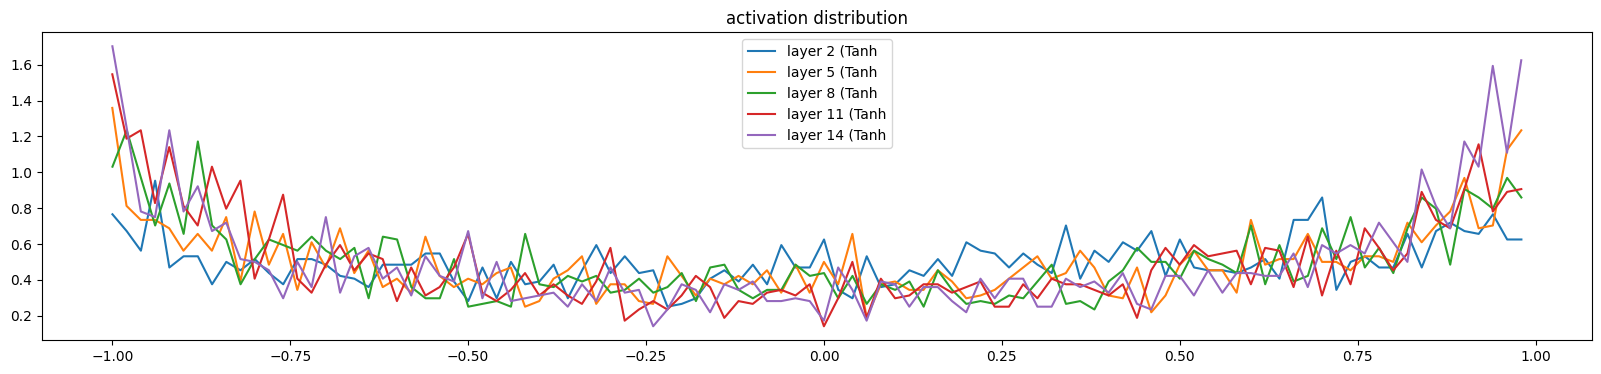

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [57]:
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
      print(layer)
  elif isinstance(layer, BatchNorm1d):
      print("Batch Normalization Layer:", layer)
  elif isinstance(layer, Linear):
      print("Linear Layer:", layer)

Linear Layer: <__main__.Linear object at 0x7f133cc3b730>
Batch Normalization Layer: <__main__.BatchNorm1d object at 0x7f133cc3b700>
Linear Layer: <__main__.Linear object at 0x7f133cc3b790>
Batch Normalization Layer: <__main__.BatchNorm1d object at 0x7f133cc3ba00>
Linear Layer: <__main__.Linear object at 0x7f133cc3ba90>
Batch Normalization Layer: <__main__.BatchNorm1d object at 0x7f133cc3bac0>
Linear Layer: <__main__.Linear object at 0x7f133cc3bb50>
Batch Normalization Layer: <__main__.BatchNorm1d object at 0x7f133cc3bb80>
Linear Layer: <__main__.Linear object at 0x7f133cc3bc10>
Batch Normalization Layer: <__main__.BatchNorm1d object at 0x7f133cc3bc40>
Linear Layer: <__main__.Linear object at 0x7f133cc3bcd0>


layer 2 (      Tanh): mean +0.000000, std 3.134888e-03
layer 5 (      Tanh): mean +0.000000, std 2.951391e-03
layer 8 (      Tanh): mean -0.000000, std 2.852108e-03
layer 11 (      Tanh): mean +0.000000, std 2.899248e-03
layer 14 (      Tanh): mean +0.000000, std 2.840559e-03


Text(0.5, 1.0, 'gradient distribution')

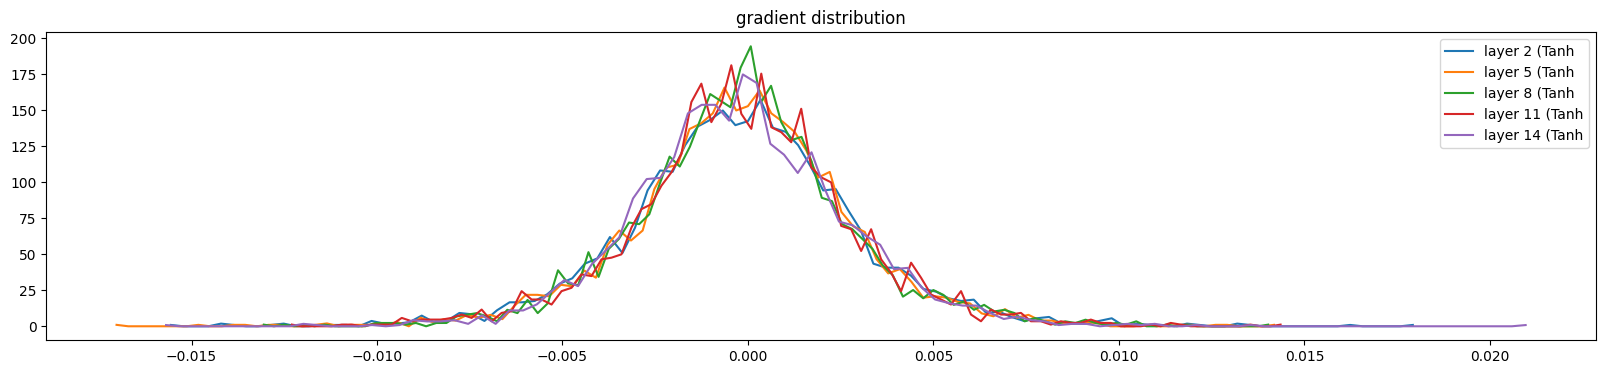

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')



weight   (27, 10) | mean -0.000000 | std 1.364604e-02 | grad:data ratio 1.222100e-02
weight  (30, 100) | mean -0.000018 | std 2.544391e-03 | grad:data ratio 1.358272e-03
weight (100, 100) | mean -0.000035 | std 2.085437e-03 | grad:data ratio 2.085798e-03
weight (100, 100) | mean +0.000002 | std 1.969663e-03 | grad:data ratio 1.950461e-03
weight (100, 100) | mean -0.000026 | std 1.873139e-03 | grad:data ratio 1.863023e-03
weight (100, 100) | mean -0.000018 | std 1.823759e-03 | grad:data ratio 1.812474e-03
weight  (100, 27) | mean -0.000031 | std 3.478626e-03 | grad:data ratio 3.490450e-03


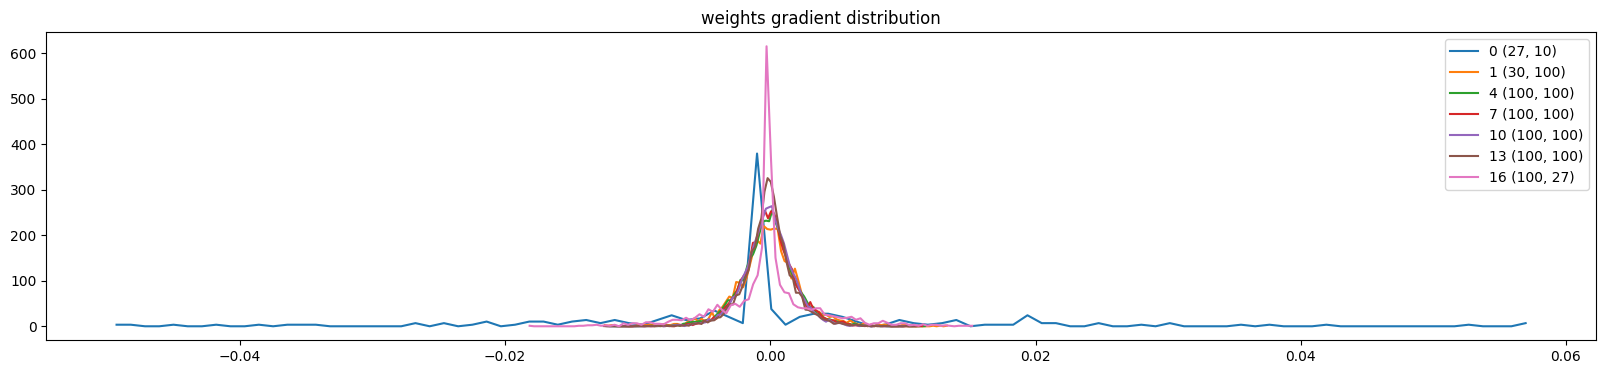

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [26]:
print(p)
print(p.grad)

tensor([ 1.2864,  2.2398, -0.6638, -0.2741,  0.1955,  1.8424, -1.5121, -1.2215,
         0.2618,  1.5659, -1.0151, -0.3359,  1.2574,  0.2656,  1.1216,  0.7224,
        -1.3882, -2.2370,  0.8993,  0.6682,  0.2577, -0.3993, -0.5960, -1.5226,
        -1.9435,  1.1803, -0.6552], requires_grad=True)
tensor([ 0.0412,  0.0789,  0.0124,  0.0136, -0.0384, -0.0078,  0.0038,  0.0069,
        -0.0482, -0.0139, -0.0161, -0.0106, -0.0278,  0.0304,  0.0468,  0.0326,
         0.0044,  0.0013, -0.0311, -0.0919, -0.0102,  0.0119, -0.0197,  0.0055,
         0.0029,  0.0114,  0.0112])


2
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1


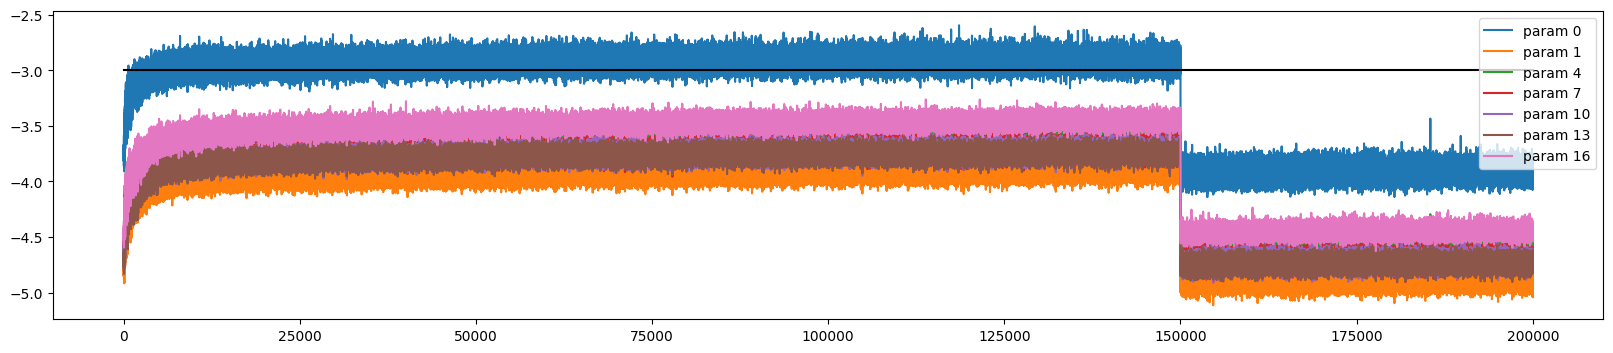

In [59]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  print(p.ndim)
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


